In [1]:
%cd /home/a_razumov/projects/k-space-mri
%env CUDA_VISIBLE_DEVICES=1
import numpy as np
import pylab as plt
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

from k_space_reconstruction.utils.metrics import pt_msssim, pt_ssim
from k_space_reconstruction.datasets.acdc import ACDCSet, ACDCTransform, RandomMaskFunc
from k_space_reconstruction.datasets.fastmri import FastMRIh5Dataset, FastMRITransform, LegacyFastMRIh5Dataset
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt

import os
import sys
from k_space_reconstruction.nets.unet import Unet
from k_space_reconstruction.nets.enet import ENet
from k_space_reconstruction.nets.mwcnn import MWCNN
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
plt.style.use('dark_background')
import albumentations
import numpy as np
import h5py
import pylab as plt
import torch
import torch.nn.functional as F

import os
import re
import numpy as np
import pandas as pd
import nibabel

import torch
import torch.utils.data
import torchvision.transforms as transforms

from os.path import isdir, join
from typing import Callable, Dict, List, Any

/home/a_razumov/projects/k-space-mri
env: CUDA_VISIBLE_DEVICES=1


In [2]:
fig_bezzeless = lambda nc, nr : plt.subplots(ncols=nc, nrows=nr, figsize=(2 * nc, 4), dpi=100, 
                                             subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                                             gridspec_kw=dict(wspace=0.0, hspace=0.0))


def tversky_loss(true, logits, alpha=0.7, beta=0.3, eps=1e-11):
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = torch.nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    fps = torch.sum(probas * (1 - true_1_hot), dims)
    fns = torch.sum((1 - probas) * true_1_hot, dims)
    num = intersection
    denom = intersection + (alpha * fps) + (beta * fns)
    tversky_loss = (num / (denom + eps)).mean()
    return (1 - tversky_loss)


def dice_loss(true, logits, eps=1e-11):
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = torch.nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)


class BraTS3dDataset(torch.utils.data.Dataset):

    def __init__(self, hf_path: str, aug=None):
        super().__init__()
        self.hf = h5py.File(hf_path)
        self.aug = aug

    def __len__(self) -> int:
        return len(self.hf)
    
    def __getitem__(self, item: int):
        img = self.hf[str(item)][:-1,:,:,:]
        mask = self.hf[str(item)][-1:,:,:,:]
        mask[mask==4] = 3
        if self.aug:
            aug = self.aug(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask).long()
        img = img.movedim(3,1)
        mask = mask.movedim(3,1)
        mean = img.mean(dim=(2,3)).unsqueeze(2).unsqueeze(2)
        std = img.std(dim=(2,3)).unsqueeze(2).unsqueeze(2)
#         mean = img.mean().unsqueeze(0).unsqueeze(0).unsqueeze(0)
#         std = img.std().unsqueeze(0).unsqueeze(0).unsqueeze(0)
        img = (img - mean) / (std + 1e-11)
        return mask, img, mean, std


class BraTS2dDataset(torch.utils.data.Dataset):

    def __init__(self, hf_path: str, aug1=None, aug2=None, slices=None):
        super().__init__()
        self.hf = h5py.File(hf_path)
        self.aug1 = aug1
        self.aug2 = aug2
        if slices:
            self.slices = slices
        else:
            self.slices = []
            for k in tqdm(self.hf.keys()):
                for j in range(self.hf[k].shape[-1]):
                    if self.hf[k][:,:,:,j].max() != 0.:
                        self.slices.append((k, j))

    def __len__(self) -> int:
        return len(self.slices)
    
    def __getitem__(self, item: int):
        key, idx = self.slices[item]
        img = self.hf[key][:-1,:,:,idx]
        mask = self.hf[key][-1:,:,:,idx]
        mask[mask==4] = 3
        if self.aug1:
            aug = self.aug1(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
        img = torch.tensor(img).float()
        if self.aug2:
            img = self.aug2(img.unsqueeze(0))[0]
        mask = torch.tensor(mask).long()
        mean = img.mean().unsqueeze(0).unsqueeze(0).unsqueeze(0)
        std = img.std().unsqueeze(0).unsqueeze(0).unsqueeze(0)
        img = (img - mean) / (std + 1e-11) + 1e-11
        return mask, img, mean, std

In [3]:
def pt_psnr(img1, img2, maxval):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

In [4]:
import torchio
augmentation = torchio.transforms.Compose([
    torchio.transforms.OneOf([
        torchio.transforms.RandomGhosting(),
        torchio.transforms.RandomBiasField(),
        torchio.transforms.RandomNoise(),
    ]),
])
np.random.seed(42)
torch.manual_seed(42)

In [5]:
import pickle
with open('notebooks/dls/brats_train.cache', 'rb') as f:
    tc = pickle.load(f)
with open('notebooks/dls/brats_val.cache', 'rb') as f:
    vc = pickle.load(f)

train_dataset = BraTS2dDataset('../../small_datasets/brats_h5/train.h5', slices=tc)
val_dataset = BraTS2dDataset('../../small_datasets/brats_h5/val.h5', slices=vc)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=80, shuffle=True, num_workers=26)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=80, shuffle=False, num_workers=26)

In [6]:
len(train_dataset), len(val_dataset)

(35508, 15391)

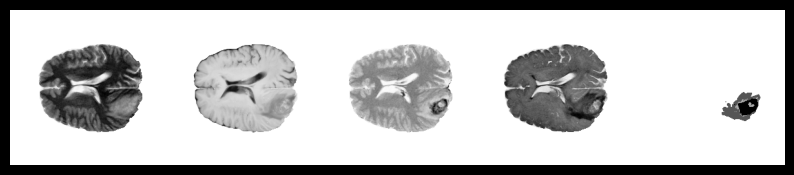

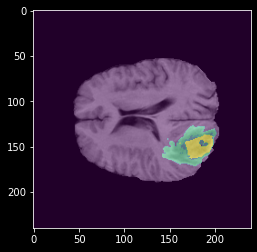

In [7]:
fig, ax = fig_bezzeless(5,1)
mask, img, mean, std = val_dataset[80]
for i in range(4):
    ax[i].imshow(img[i], cmap=plt.cm.Greys)
ax[-1].imshow(mask[0], cmap=plt.cm.binary)
plt.show()
plt.imshow(img[0], cmap=plt.cm.gray)
plt.imshow(mask[0], alpha=0.5)
plt.show()

In [8]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = Unet(4, 4).to(device).train(False).eval()
for p in model.parameters():
    p.requires_grad = False
model.load_state_dict(torch.load('notebooks/dls/unet-brats-norot-3.pt'))

<All keys matched successfully>

tensor(0.8808, device='cuda:0')


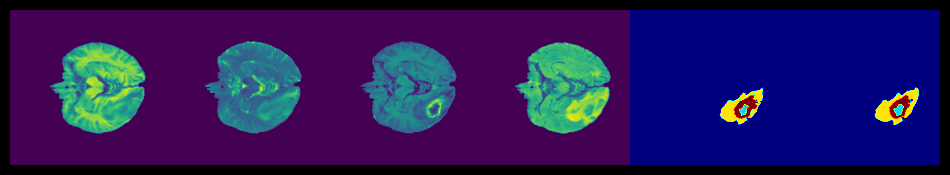

In [9]:
mask, img, mean, std = val_dataset[50]
with torch.no_grad():
    pred = model(img.unsqueeze(0).cuda())[0]
probas = F.softmax(pred, dim=0)
pmask = torch.zeros_like(mask)
probas[probas > 0.5] = 1
probas[probas <= 0.5] = 0
pmask[0] = probas[1] * 1 + probas[2] * 2 + probas[3] * 3

fig, ax = fig_bezzeless(6,1)
for i in range(4):
    ax[i].imshow(img[i])
ax[-2].imshow(mask[0], cmap=plt.cm.jet)
ax[-1].imshow(pmask[0], cmap=plt.cm.jet)
print(1 - dice_loss(mask.unsqueeze(0), pred.unsqueeze(0)))
plt.show()

In [10]:
mask, img, mean, std = val_dataset[50]
pred = model(img.unsqueeze(0).cuda())[0]
print(1 - dice_loss(mask.unsqueeze(0).cuda(), pred.unsqueeze(0)))

ks = Ft(img * std + mean)
gt = (IFt(ks).abs() - mean) / (std + 1e-11)

pred = model(gt.unsqueeze(0).cuda())[0]
print(1 - dice_loss(mask.unsqueeze(0).cuda(), pred.unsqueeze(0)))

tensor(0.8808, device='cuda:0')
tensor(0.8808, device='cuda:0')


In [11]:
ks.shape

torch.Size([4, 240, 240])

In [12]:
torch.cuda.empty_cache()

In [25]:
w = torch.zeros(4,240).cuda().float()
w[:,120] = 1
w_list = []

bbatch_size = 110

pbar = tqdm(range(16))
for count in pbar:
    w = torch.autograd.Variable(w, requires_grad=True)
    for mask, img, mean, std in tqdm(train_generator, leave=False):
        mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
        ks = Ft(img * std + mean)
        img = (IFt(ks * w.unsqueeze(0).unsqueeze(3)).abs() - mean) / (std + 1e-11)
        pred = model(img)
        loss = dice_loss(mask, pred)
        if torch.isnan(loss):
            print('warn')
            continue
        loss.backward()
    w_grad = w.grad.cpu().detach()
    w = w.detach()
    for j in range(4):
        for i in torch.topk(w_grad[j,:], 240, largest=False).indices:
            if w[j,i] == 0: 
                w[j,i] = 1.
                print('select: %d, loss: %.6f' % (i.item(), loss.item()))
                break
    w_list.append(w.clone())

select: 115, loss: 0.729012
select: 119, loss: 0.729012
select: 124, loss: 0.729012
select: 119, loss: 0.729012


select: 119, loss: 0.716358
select: 117, loss: 0.716358
select: 119, loss: 0.716358
select: 124, loss: 0.716358


select: 117, loss: 0.629619
select: 121, loss: 0.629619
select: 117, loss: 0.629619
select: 123, loss: 0.629619


select: 121, loss: 0.604783
select: 115, loss: 0.604783
select: 121, loss: 0.604783
select: 117, loss: 0.604783


select: 123, loss: 0.500807
select: 118, loss: 0.500807
select: 123, loss: 0.500807
select: 121, loss: 0.500807


select: 122, loss: 0.371126
select: 124, loss: 0.371126
select: 122, loss: 0.371126
select: 125, loss: 0.371126


select: 116, loss: 0.365977
select: 122, loss: 0.365977
select: 115, loss: 0.365977
select: 118, loss: 0.365977


select: 118, loss: 0.370283
select: 125, loss: 0.370283
select: 118, loss: 0.370283
select: 114, loss: 0.370283


select: 124, loss: 0.360745
select: 123, loss: 0.360745
select: 127, loss: 0.360745
select: 127, loss: 0.360745


select: 125, loss: 0.310547
select: 114, loss: 0.310547
select: 111, loss: 0.310547
select: 113, loss: 0.310547


select: 127, loss: 0.317164
select: 126, loss: 0.317164
select: 125, loss: 0.317164
select: 110, loss: 0.317164


select: 129, loss: 0.257717
select: 128, loss: 0.257717
select: 131, loss: 0.257717
select: 129, loss: 0.257717


select: 112, loss: 0.274725
select: 113, loss: 0.274725
select: 113, loss: 0.274725
select: 130, loss: 0.274725


select: 113, loss: 0.251192
select: 112, loss: 0.251192
select: 112, loss: 0.251192
select: 111, loss: 0.251192


select: 114, loss: 0.237875
select: 130, loss: 0.237875
select: 133, loss: 0.237875
select: 115, loss: 0.237875


select: 111, loss: 0.242978
select: 110, loss: 0.242978
select: 126, loss: 0.242978
select: 131, loss: 0.242978



In [30]:
len(w_list)

16

In [27]:
# torch.save(w_list, 'notebooks/dls/brats_n37r_unet-norot.pt')

In [83]:
w_list = torch.load('notebooks/dls/brats_n37r_unet-norot.pt')

In [84]:
w_list[0].shape

torch.Size([4, 240])

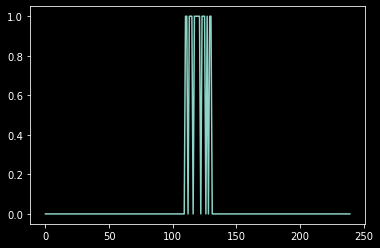

In [88]:
plt.plot(w_list[14][3].cpu())
plt.show()

In [89]:
w_list[14].unsqueeze(2).shape

torch.Size([4, 240, 1])

In [90]:
torch.cuda.empty_cache()

17.33634376525879
0.5388565063476562


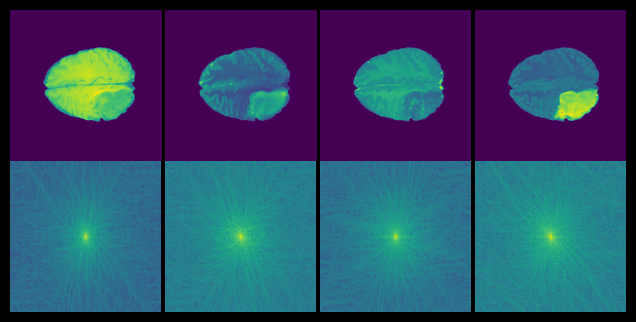

17.335674285888672
0.5455857515335083


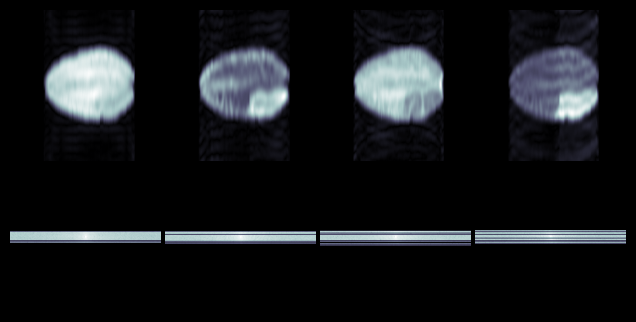

17.33578872680664
0.48753464221954346


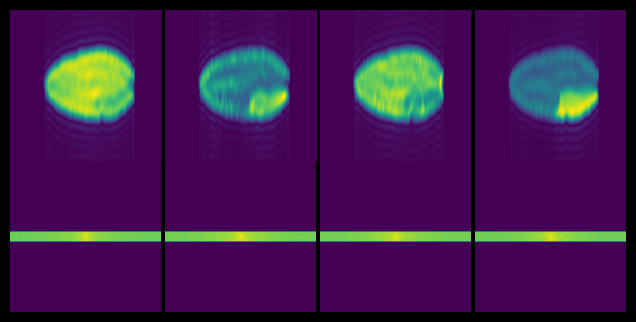

17.335670471191406
0.4264037609100342


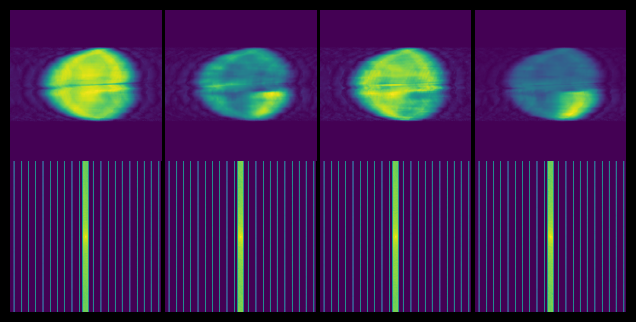

In [91]:
mask, img, mean, std = val_dataset[250]
ks = Ft(img * std + mean)
gt = IFt(ks).abs()

w = w_list[14].unsqueeze(2)

img = (IFt(ks.cuda()).abs() - mean.cuda()) / (std.cuda() + 1e-11)
with torch.no_grad():
    pred = model(img.unsqueeze(0).cuda())[0]
print(pt_psnr(gt, img.cpu(), maxval=gt.max()).item())
print(1 - dice_loss(mask.unsqueeze(0).cuda(), pred.unsqueeze(0)).item())
fig, ax = fig_bezzeless(4,2)
for i in range(4): ax[0,i].imshow(img[i].cpu())
for i in range(4): ax[1,i].imshow((ks.cuda()[i].abs() + 1e-11).log().cpu().detach())
plt.show()


img = (IFt(ks.cuda() * w).abs() - mean.cuda()) / (std.cuda() + 1e-11)
with torch.no_grad():
    pred = model(img.unsqueeze(0).cuda())[0]
print(pt_psnr(gt, img.cpu(), maxval=gt.max()).item())
print(1 - dice_loss(mask.unsqueeze(0).cuda(), pred.unsqueeze(0)).item())
fig, ax = fig_bezzeless(4,2)
for i in range(4): ax[0,i].imshow(img[i].cpu(), cmap=plt.cm.bone)
for i in range(4): ax[1,i].imshow(((ks.cuda() * w)[i].abs() + 1e-11).log().cpu().detach(), cmap=plt.cm.bone)
plt.show()

zm = torch.zeros(240).cuda()
zm[240//2 - int(w[0].sum())//2 : 240//2 + int(w[0].sum())//2] = 1
zm = zm.unsqueeze(0).unsqueeze(2)

img = (IFt(ks.cuda() * zm).abs() - mean.cuda()) / (std.cuda() + 1e-11)
with torch.no_grad():
    pred = model(img.unsqueeze(0).cuda())[0]
print(pt_psnr(gt, img.cpu(), maxval=gt.max()).item())
print(1 - dice_loss(mask.unsqueeze(0).cuda(), pred.unsqueeze(0)).item())
fig, ax = fig_bezzeless(4,2)
for i in range(4): ax[0,i].imshow(img[i].cpu())
for i in range(4): ax[1,i].imshow(((ks.cuda() * zm)[i].abs() + 1e-11).log().cpu().detach())
plt.show()

fastmri_mask_x8 = torch.tensor(EquispacedMaskFunc([0.04], [8])((240, 240))[0]).cuda()
img = (IFt(ks.cuda() * fastmri_mask_x8).abs() - mean.cuda()) / (std.cuda() + 1e-11)
with torch.no_grad():
    pred = model(img.unsqueeze(0).cuda())[0]
print(pt_psnr(gt, img.cpu(), maxval=gt.max()).item())
print(1 - dice_loss(mask.unsqueeze(0).cuda(), pred.unsqueeze(0)).item())
fig, ax = fig_bezzeless(4,2)
for i in range(4): ax[0,i].imshow(img[i].cpu())
for i in range(4): ax[1,i].imshow(((ks.cuda() * fastmri_mask_x8)[i].abs() + 1e-11).log().cpu().detach())
plt.show()

In [92]:
print(EquispacedMaskFunc([0.04], [15])((240, 240))[0].sum(), w_list[14][0].sum())

16.0 tensor(16., device='cuda:0')


In [93]:
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(w_list[14][0].sum())//2 : 240//2 + int(w_list[14][0].sum())//2] = 1
zm = zm.unsqueeze(0).unsqueeze(2)
zm.sum()

tensor(16., device='cuda:0')

In [94]:
def dice_coeff_3d(true, logits, eps=1e-11):
    num_classes = logits.shape[0]
    probas = torch.nn.functional.softmax(logits, dim=0)
    probas[probas > 0.5] = 1
    probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes): pmask[0] += probas[i] * i
    dice_coeff = 0.
    for i in range(1, num_classes):
        true_1_hot = (true==i).float().flatten()
        pred_1_hot = (pmask==i).float().flatten()
#         true_1_hot = torch.zeros_like(pmask)
#         pred_1_hot = torch.zeros_like(pmask)
#         for j in range(1, i+1):
#             true_1_hot[true==i] = 1
#             pred_1_hot[pmask==i] = 1
        intersection = torch.sum(pred_1_hot * true_1_hot)
        cardinality = torch.sum(pred_1_hot + true_1_hot)
        dice_coeff += (2. * intersection / (cardinality + eps))
#         print(dice_coeff)
    return dice_coeff / (num_classes - 1)

In [95]:
val_3d_dataset = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/val.h5')

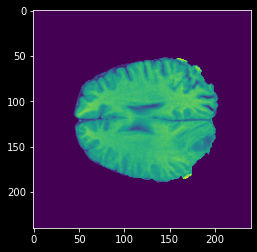

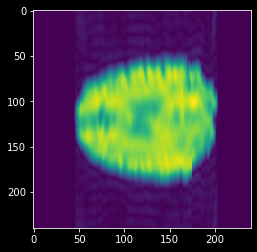

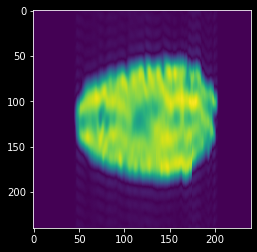

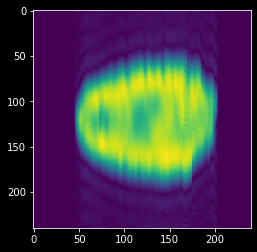

In [96]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cuda().float()
fastmri_mask_x16 = fastmri_mask_x16.unsqueeze(1).unsqueeze(0).unsqueeze(0)

sampling_igs = w_list[14].cuda().float().unsqueeze(2).unsqueeze(1)

zm = torch.zeros(240).cuda().float()
zm[240//2 - int(sampling_igs[0].sum())//2 : 240//2 + int(sampling_igs[0].sum())//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)

dice_scores_full = []
dice_scores_igs = []
dice_scores_cnt = []
dice_scores_x16 = []

# with torch.no_grad():
#     for i in tqdm(range(len(val_dataset))):
#         mask, img, mean, std = val_dataset[i]
#         mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
#         ks = Ft(img * std + mean)
#         #full
#         img = (IFt(ks).abs() - mean) / (std + 1e-11)
#         pred = model(img.unsqueeze(0))[0]
#         dice_scores_full.append(1 - dice_loss(mask.unsqueeze(0), pred.unsqueeze(0)).item())
#         #igs
#         img = (IFt(ks * sampling_igs).abs() - mean) / (std + 1e-11)
#         pred = model(img.unsqueeze(0))[0]
#         dice_scores_igs.append(1 - dice_loss(mask.unsqueeze(0), pred.unsqueeze(0)).item())
#         #cnt
#         img = (IFt(ks * zm).abs() - mean) / (std + 1e-11)
#         pred = model(img.unsqueeze(0))[0]
#         dice_scores_cnt.append(1 - dice_loss(mask.unsqueeze(0), pred.unsqueeze(0)).item())
#         #fastmri
#         img = (IFt(ks * fastmri_mask_x16).abs() - mean) / (std + 1e-11)
#         pred = model(img.unsqueeze(0))[0]
#         dice_scores_x16.append(1 - dice_loss(mask.unsqueeze(0), pred.unsqueeze(0)).item())

with torch.no_grad():
    for i in tqdm(range(len(val_3d_dataset))):
        mask, img, mean, std = val_3d_dataset[i]
        mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
        ks = Ft(img * std + mean)
        #full
        img = (IFt(ks).abs() - mean) / (std + 1e-11)
        if i==0: plt.imshow(img[0,90].cpu().detach()); plt.show()
        pred = model(img.movedim(1,0))
        dice_scores_full.append(dice_coeff_3d(mask, pred.movedim(1,0)).item())
        #igs
        img = (IFt(ks * sampling_igs).abs() - mean) / (std + 1e-11)
        if i==0: plt.imshow(img[0,90].cpu().detach()); plt.show()
        pred = model(img.movedim(1,0))
        dice_scores_igs.append(dice_coeff_3d(mask, pred.movedim(1,0)).item())
        #cnt
        img = (IFt(ks * zm).abs() - mean) / (std + 1e-11)
        if i==0: plt.imshow(img[0,90].cpu().detach()); plt.show()
        pred = model(img.movedim(1,0))
        dice_scores_cnt.append(dice_coeff_3d(mask, pred.movedim(1,0)).item())
        #fastmri
        img = (IFt(ks * fastmri_mask_x16).abs() - mean) / (std + 1e-11)
        if i==0: plt.imshow(img[0,90].cpu().detach()); plt.show()
        pred = model(img.movedim(1,0))
        dice_scores_x16.append(dice_coeff_3d(mask, pred.movedim(1,0)).item())

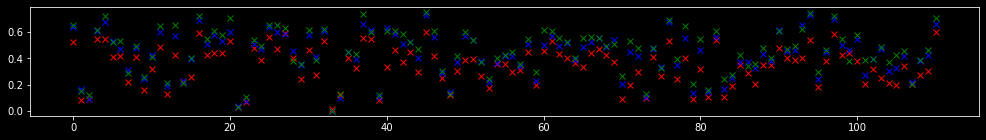

In [126]:
plt.figure(figsize=(17,2))
plt.plot(np.array(dice_scores_x16), 'rx')
plt.plot(np.array(dice_scores_cnt), 'bx')
plt.plot(np.array(dice_scores_igs), 'gx')
plt.show()

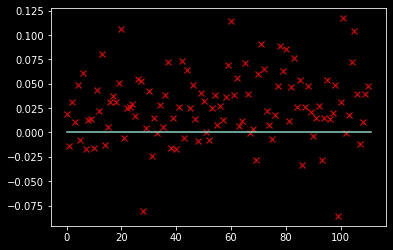

In [121]:
plt.plot(np.array(dice_scores_igs) - np.array(dice_scores_cnt), 'rx')
plt.plot([0,len(dice_scores_igs)], [0,0])
plt.show()

0.4810517728328705 0.46054190397262573
0.4590778433217188 0.43194587116847066


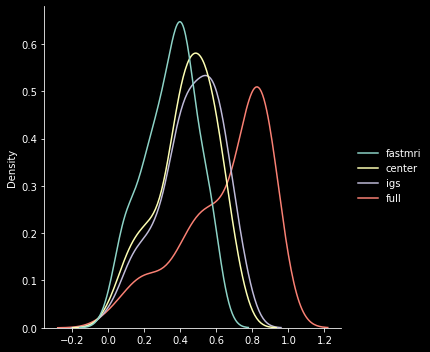

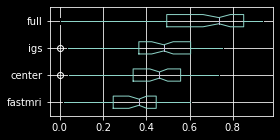

Ttest_indResult(statistic=1.1773207253528148, pvalue=0.24033962142072718)


,fastmri,center,igs,full
count,111.000000,111.000000,111.000000,111.000000
mean,0.344996,0.431946,0.459078,0.648563
std,0.147081,0.168953,0.174375,0.239449
min,0.013669,0.000573,0.000033,0.000000
25%,0.246735,0.338850,0.365310,0.494248
50%,0.365927,0.460542,0.481052,0.735519
75%,0.445573,0.558496,0.604717,0.850151
max,0.605595,0.734553,0.754936,0.938259


In [97]:
import scipy
import seaborn as sns
import pandas as pd

df_dice = pd.DataFrame.from_dict({
    'fastmri': dice_scores_x16,
    'center': dice_scores_cnt,
    'igs': dice_scores_igs,
    'full': dice_scores_full,
})
print(df_dice.igs.median(), df_dice.center.median())
print(df_dice.igs.mean(), df_dice.center.mean())
sns.displot(df_dice, kind='kde')
plt.show()
plt.figure(figsize=(4,2))
df_dice.boxplot(notch=True, vert=False, bootstrap=1000)
plt.show()
print(scipy.stats.ttest_ind(df_dice.igs.tolist(), df_dice.center.tolist()))
df_dice.describe()

In [42]:
mask.flatten().shape

torch.Size([8928000])

In [83]:
# def dice_coeff_3d(true, logits, eps=1e-11):
#     num_classes = logits.shape[0]
#     probas = torch.nn.functional.softmax(logits, dim=0)
#     dice_coeff = 0.
#     for i in range(1, num_classes):
# #         true_1_hot = torch.zeros_like(true)
# #         for j in range(1, i+1): true_1_hot[true==i] = 1
#         true_1_hot = (true==i).float().flatten()
# #         true_1_hot = true_1_hot.float().flatten()
#         intersection = torch.sum(probas[i].flatten() * true_1_hot)
#         cardinality = torch.sum(probas[i].flatten() + true_1_hot)
#         dice_coeff += (2. * intersection / (cardinality + eps))
#         print(dice_coeff)
#     return dice_coeff / (num_classes - 1)

def dice_coeff_3d(true, logits, eps=1e-11):
    num_classes = logits.shape[0]
    probas = torch.nn.functional.softmax(logits, dim=0)
    probas[probas > 0.5] = 1
    probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(mask).float()
    for i in range(1, num_classes): pmask[0] += probas[i] * i
    dice_coeff = 0.
    for i in range(1, num_classes):
        true_1_hot = (true==i).float().flatten()
        pred_1_hot = (pmask==i).float().flatten()
        intersection = torch.sum(pred_1_hot * true_1_hot)
        cardinality = torch.sum(pred_1_hot + true_1_hot)
        dice_coeff += (2. * intersection / (cardinality + eps))
        print(dice_coeff)
    return dice_coeff / (num_classes - 1)

0.786145031452179
tensor(0.8953)
tensor(1.5996)
tensor(2.3962)
0.7987415790557861


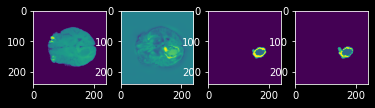

In [85]:
z = 70

mask, img, mean, std  = val_3d_dataset[80]
with torch.no_grad():
    pred = model(img.movedim(1,0).cuda()).cpu()
probas = F.softmax(pred, dim=1)
probas[probas > 0.5] = 1
probas[probas <= 0.5] = 0
pmask = torch.zeros_like(mask)
pmask[0] = probas[:,1] * 1 + probas[:,2] * 2 + probas[:,3] * 3
print(1 - dice_loss(mask.movedim(1,0)[z].unsqueeze(0), pred[z].unsqueeze(0)).item())
print(dice_coeff_3d(mask, pred.movedim(1,0)).item())
fig, ax = plt.subplots(ncols=4)
ax[0].imshow(img[0,z])
ax[1].imshow(pred[z,2])
ax[2].imshow(mask[0,z])
ax[3].imshow(pmask[0,z])
plt.show()

In [78]:
mask.shape, pred.movedim(1,0).shape

(torch.Size([1, 155, 240, 240]), torch.Size([4, 155, 240, 240]))

In [327]:
dice = 0
for i in range(1,4):
    dice += 2 * ((pmask==i).float() * (mask==i).float()).sum() / (((pmask==i).float() + (mask==i).float()).sum())
dice /= 3
print(dice)

tensor(0.8499)


0.24999958276748657


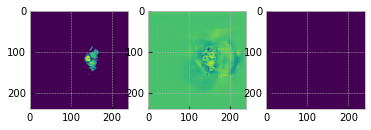

In [313]:
mask, img, mean, std = val_dataset[0]
with torch.no_grad():
    pred = model(img.unsqueeze(0).cuda()).cpu()[0]
probas = F.softmax(pred, dim=0)
probas[probas > 0.5] = 1
probas[probas <= 0.5] = 0
pmask = torch.zeros_like(mask)
pmask[0] = probas[1] * 1 + probas[2] * 2 + probas[3] * 3
print(1 - dice_loss(mask.unsqueeze(0), pred.unsqueeze(0)).item())
fig, ax = plt.subplots(ncols=3)
ax[0].imshow(img[0])
ax[1].imshow(pred[2])
ax[2].imshow(pmask[0])
plt.show()

0.268290638923645


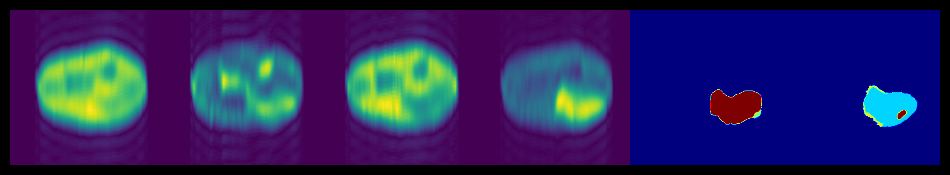

0.2909277677536011


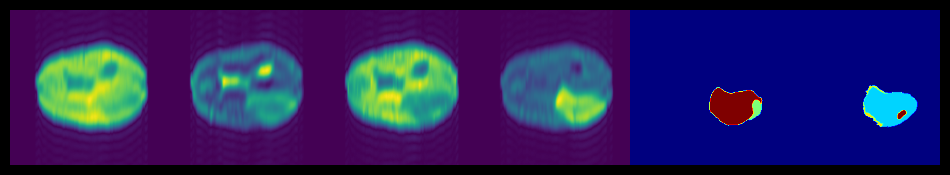

0.2949259281158447


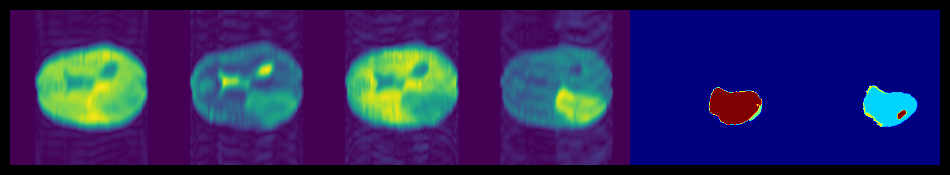

In [104]:
val_3d_dataset = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/val.h5')

def plot_seg_result(sampling, N, slize_z):
    mask, img, mean, std  = val_3d_dataset[N]
    mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
    img = IFt(Ft(img * std + mean) * sampling).abs()
    img = (img - mean) / (std + 1e-11)

    with torch.no_grad():
        pred = model(img.movedim(1,0))

    probas = F.softmax(pred, dim=1)
    probas[probas > 0.5] = 1
    probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(mask)
    pmask[0] = probas[:,1] * 1 + probas[:,2] * 2 + probas[:,3] * 3

    print(1 - dice_loss(mask.movedim(1,0), pred).item())
    fig, ax = fig_bezzeless(nc=6,nr=1)
    ax[0].imshow(img.cpu().numpy()[0,slice_z])
    ax[1].imshow(img.cpu().numpy()[1,slice_z])
    ax[2].imshow(img.cpu().numpy()[2,slice_z])
    ax[3].imshow(img.cpu().numpy()[3,slice_z])
    ax[4].imshow(pmask.cpu().numpy()[0,slice_z], cmap=plt.cm.jet)
    ax[5].imshow(mask.cpu().numpy()[0,slice_z], cmap=plt.cm.jet)
    plt.show()

N = 1
slice_z = 80

plot_seg_result(fastmri_mask_x16, N, slice_z)
plot_seg_result(zm, N, slice_z)
plot_seg_result(sampling_igs, N, slice_z)

In [23]:
def get_scores(sampling):
    scores = {'ssim': [], 'psnr': [], 'dice': []}
    
    for i in range(len(val_3d_dataset)):
        mask, gt, mean, std = val_3d_dataset[i]
        mask = mask.cuda(); gt = gt.cuda(); mean = mean.cuda(); std = std.cuda()
        ks = Ft(gt * std + mean)
        img = (IFt(ks * sampling).abs() - mean) / (std + 1e-11)
        pred = model(img.movedim(1,0))
        scores['dice'].append(1 - dice_loss(mask.movedim(1,0), pred).item())
        scores['psnr'].append(float(pt_psnr(gt, img, maxval=img.max()).item()))
        scores['ssim'].append(float(pt_ssim(gt, img, val_range=gt.max()).item()))
    return scores

In [41]:
list(range(0,60,4))

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56]

In [42]:
dls_results = []
zm_results = []

# for i in tqdm(range(len(w_list))):
pbar = tqdm(range(0,60,4))
# pbar = tqdm(range(len(w_list)))
for i in pbar:
    sampling_igs = w_list[i].cuda().float().unsqueeze(1)
    zm = torch.zeros(240).cuda().float()
    zm[240//2 - int(sampling_igs[0].sum())//2 : 240//2 + int(sampling_igs[0].sum())//2] = 1
    dls_results.append(get_scores(sampling_igs))
    zm_results.append(get_scores(zm))
    pbar.set_description('%.5f | %.5f' % (np.mean(dls_results[-1]['dice']), np.mean(zm_results[-1]['dice'])))

0.73457 | 0.73302: 100%|██████████| 15/15 [52:11<00:00, 208.74s/it]


In [43]:
np.mean(zm_results[0]['dice'])

0.3640263612205918

In [44]:
import pickle

with open('notebooks/dls/dlsampling-brats-segmentation-unet-ax-dice.pkl', 'wb') as f:
    pickle.dump({'dls': dls_results, 'center': zm_results}, f)

In [45]:
np.mean(dls_results[-10]['dice']), np.mean(zm_results[-10]['dice'])

(0.6666252269401206, 0.6599195094795914)

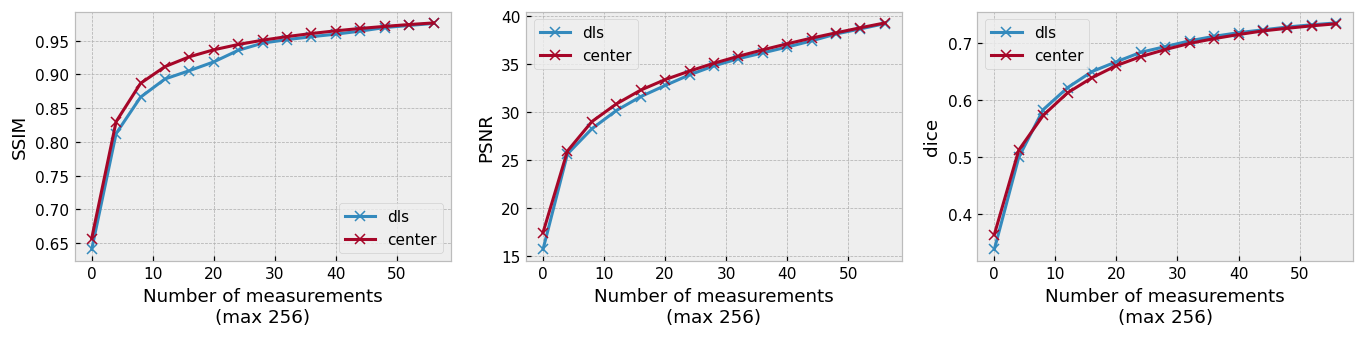

In [46]:
plt.style.use('bmh')

x_phase = list(range(0,60,4))

fig, ax = plt.subplots(ncols=3, figsize=(15,3), dpi=110)
pd_res = pd.DataFrame.from_dict({
    'dls': [torch.tensor(r['ssim']).mean().item() for r in dls_results],
    'center': [torch.tensor(r['ssim']).mean().item() for r in zm_results]
})

ax[0].plot(x_phase, pd_res.dls, 'x-', label='dls')
ax[0].plot(x_phase, pd_res.center, 'x-', label='center')
ax[0].legend()
ax[0].set_xlabel('Number of measurements\n(max 256)')
ax[0].set_ylabel('SSIM')

pd_res = pd.DataFrame.from_dict({
    'dls': [torch.tensor(r['psnr']).mean().item() for r in dls_results],
    'center': [torch.tensor(r['psnr']).mean().item() for r in zm_results]
})

ax[1].plot(x_phase, pd_res.dls, 'x-', label='dls')
ax[1].plot(x_phase, pd_res.center, 'x-', label='center')
ax[1].legend()
ax[1].set_xlabel('Number of measurements\n(max 256)')
ax[1].set_ylabel('PSNR')

pd_res = pd.DataFrame.from_dict({
    'dls': [torch.tensor(r['dice']).mean().item() for r in dls_results],
    'center': [torch.tensor(r['dice']).mean().item() for r in zm_results]
})

ax[2].plot(x_phase, pd_res.dls, 'x-', label='dls')
ax[2].plot(x_phase, pd_res.center, 'x-', label='center')
ax[2].legend()
ax[2].set_xlabel('Number of measurements\n(max 256)')
ax[2].set_ylabel('dice')

plt.show()

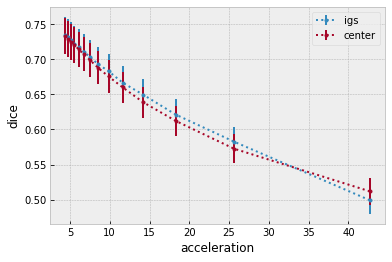

In [47]:
from scipy import stats

def sem(x):
    return 1.96 * np.std(x) / np.sqrt(len(x))

plt.errorbar(
    x=[256 / (v+2) for v in x_phase[1:]], 
    y=[np.mean(v['dice']) for v in dls_results[1:]],
    yerr=[sem(v['dice']) for v in dls_results[1:]], 
    linestyle=':', marker='.',
    label='igs'
)
plt.errorbar(
    x=[256 / (v+2) for v in x_phase[1:]], 
    y=[np.mean(v['dice']) for v in zm_results[1:]], 
    yerr=[sem(v['dice']) for v in zm_results[1:]], 
    linestyle=':', marker='.',
    label='center'
)
plt.xlabel('acceleration')
plt.ylabel('dice')
plt.legend()
plt.show()

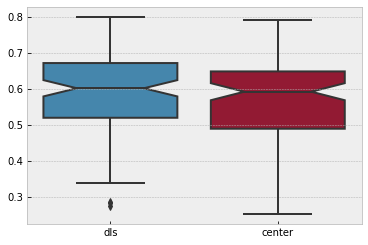

KstestResult(statistic=0.09009009009009009, pvalue=0.7610102369796172)


In [50]:
import seaborn as sns
from scipy.stats import ks_2samp

pd_res = pd.DataFrame.from_dict({
    'dls': dls_results[2]['dice'],
    'center': zm_results[2]['dice']
})

sns.boxplot(data=pd_res, notch=True)
plt.show()
print(ks_2samp(pd_res.dls, pd_res.center))

In [25]:
def dice_coef(mask1, mask2, c):
    y_true = torch.zeros_like(mask1.clone())
    y_true[mask1==c] = 1
    y_pred = torch.zeros_like(mask2.clone())
    y_pred[mask2==c] = 1
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-11) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + 1e-11)

def get_mask(img, mask):
    pred = model(img.movedim(1,0))
    probas = F.softmax(pred, dim=1)
    probas[probas > 0.5] = 1
    probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(mask)
    pmask[0] = probas[:,1] * 1 + probas[:,2] * 2 + probas[:,3] * 3
    return pmask

def get_acceleration_dice_scores(x):
    fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [x])((240, 240))[0]).cuda().float()
    sampling_igs = w_list[int(fastmri_mask_x16.sum() - 2)].cuda().float().unsqueeze(1)
    zm = torch.zeros(240).cuda().float()
    zm[240//2 - int(sampling_igs[0].sum())//2 : 240//2 + int(sampling_igs[0].sum())//2] = 1
    
    dice_full = {'0':[], '1':[], '2':[], '3':[]}
    dice_dls = {'0':[], '1':[], '2':[], '3':[]}
    dice_cnt = {'0':[], '1':[], '2':[], '3':[]}
    dice_x16 = {'0':[], '1':[], '2':[], '3':[]}

    with torch.no_grad():
        for i in tqdm(range(len(val_3d_dataset))):
            mask, img, mean, std = val_3d_dataset[i]
            mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
            ks = Ft(img * std + mean)
            for c in [0,1,2,3]:
                #full
                img = (IFt(ks).abs() - mean) / (std + 1e-11)
                dice_full[str(c)].append(dice_coef(mask, get_mask(img, mask), c).item())
                #igs
                img = (IFt(ks * sampling_igs).abs() - mean) / (std + 1e-11)
                dice_dls[str(c)].append(dice_coef(mask, get_mask(img, mask), c).item())
                #cnt
                img = (IFt(ks * zm).abs() - mean) / (std + 1e-11)
                dice_cnt[str(c)].append(dice_coef(mask, get_mask(img, mask), c).item())
                #fastmri
                img = (IFt(ks * fastmri_mask_x16).abs() - mean) / (std + 1e-11)
                dice_x16[str(c)].append(dice_coef(mask, get_mask(img, mask), c).item())
#     df_results = pd.DataFrame({
#         'full': {k:np.mean(v) for k,v in dice_full.items()},
#         'igs': {k:np.mean(v) for k,v in dice_dls.items()},
#         'center': {k:np.mean(v) for k,v in dice_cnt.items()},
#         'fastmri': {k:np.mean(v) for k,v in dice_x16.items()},
#     })
    results = {
        'full': dice_full,
        'igs': dice_dls,
        'center': dice_cnt,
        'fastmri': dice_x16,
    }
    return results

In [36]:
list(240 / (v+2) for v in range(10,60,4))

[20.0,
 15.0,
 12.0,
 10.0,
 8.571428571428571,
 7.5,
 6.666666666666667,
 6.0,
 5.454545454545454,
 5.0,
 4.615384615384615,
 4.285714285714286,
 4.0]

In [38]:
df_x_ls = []
for i in range(10,60,4):
    df_x_ls.append(get_acceleration_dice_scores(240 / (i+2)))

 75%|███████▍  | 83/111 [10:55<03:40,  7.89s/it]


KeyboardInterrupt: 

In [7]:
import pickle

# df_x = [df_x16, df_x14, df_x12, df_x10, df_x8, df_x6, df_x4]

with open('notebooks/dls/dlsampling-brats-segmentation-unet-dice-x.pkl', 'rb') as f:
    df_x = pickle.load(f)

# with open('notebooks/dls/dlsampling-brats-segmentation-unet-dice-x.pkl', 'wb') as f:
#     pickle.dump(df_x, f)

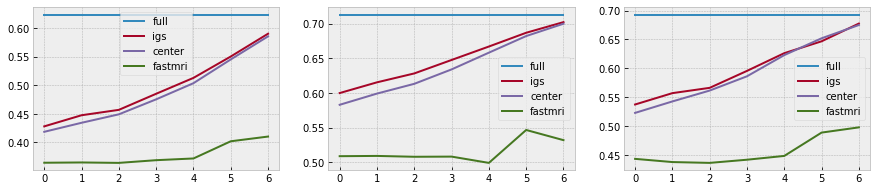

In [73]:
fig, ax = plt.subplots(ncols=3, figsize=(15,3))

for i in range(1,4):
    ax[i-1].plot([v.full[i] for v in df_x], label='full')
    ax[i-1].plot([v.igs[i] for v in df_x], label='igs')
    ax[i-1].plot([v.center[i] for v in df_x], label='center')
    ax[i-1].plot([v.fastmri[i] for v in df_x], label='fastmri')
    ax[i-1].legend()
plt.show()

In [16]:
for x in df_x:
    print(list(x.igs - x.center)[1:])
    print(x)

[0.009527944341702788, 0.016968772721451586, 0.014515468083282967]
       full       igs    center   fastmri
0  0.999008  0.998431  0.998362  0.997811
1  0.623653  0.428179  0.418651  0.364543
2  0.713223  0.599866  0.582897  0.508619
3  0.692878  0.537420  0.522904  0.443384
[0.013190770936818141, 0.01626846948135141, 0.01435703870123084]
       full       igs    center   fastmri
0  0.999008  0.998520  0.998470  0.997822
1  0.623653  0.447634  0.434443  0.365029
2  0.713223  0.615366  0.599098  0.508997
3  0.692878  0.557073  0.542716  0.437840
[0.007820911190801083, 0.015012657655788963, 0.00469287761187176]
       full       igs    center   fastmri
0  0.999008  0.998602  0.998558  0.997809
1  0.623653  0.457071  0.449251  0.364285
2  0.713223  0.628230  0.613217  0.507775
3  0.692878  0.566234  0.561541  0.436413
[0.009739324774568237, 0.013634992142518287, 0.00934838610916311]
       full       igs    center   fastmri
0  0.999008  0.998713  0.998681  0.997838
1  0.623653  0.485210 